# Tuolumne Case Study Analysis

This notebook contains code used to reproduce the results in the paper:

Kucharski, J., Steinschneider, S., Herman, J., Olszewski, J., Arnold, W., Rahat, S., Maendley, R., Ray, P. (2023). Using Process-Informed Exploratory Scenarios to Bridge the Gap between Top-Down and Bottom-up Climate Impact Assessments. [Manuscript submitted for publication].

In [1]:
import datetime as dt
from enum import Enum
from typing import List, Dict, Tuple
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms
from matplotlib.colors import LinearSegmentedColormap

import statsmodels.formula.api as smf

## Data Files

The following data files are used as inputs:

- wat_1d.csv
- wat_1m.csv
- scenariolist.csv

These files are available in the JohnRushKucharski/tuolumne_paper repository and are tracked through Git LFS. The file path strings below must be set to a local path to run the subsequent blocks of code in this notebook. 

In [2]:
wat_1dy: str # set string path to wat_1d.csv
wat_1mo: str # set string path to wat_1m.csv
scenario_list: str # set string path to scenario_list.csv
figure_dir: str # set string path to figure directory

The block contains utility functions used thoughout the notebook.

In [3]:
def filter(df: pd.DataFrame, scenario: int = 1, sim: int = None):
    '''
    Returns a dataframe, by selected only the specified scenario and simulation number (or all simulations if the default 'None' argument is used) data from the specified dataframe.
    '''
    return df.loc[(df.scenario == scenario) & (df.sim == sim)].copy(deep=True) if sim != None else df.loc[df.scenario == scenario].copy(deep=True)

## Flood Figures

The block of code below processes the data files to create dataframes used to construct several flood related figures. 

In [4]:
def flood_years(df):
    '''
    Counts the occurance of flood years in each scenario, based on the occurence in each water year of one or more days in which the simulated peak flow exceeds 9000 cfs.
    ''' 
    pd.options.mode.chained_assignment = None
    dfs = []
    df['date_sim'] = pd.to_datetime(df['date_sim'])
    df = df[(df['date_sim'] >= '2021-10-01') & (df['date_sim'] <= '2051-09-30')]
    df['scenario'] = df['scenario'].astype(int)
    df['p_mean'] = df['p_mean'].apply(lambda x: -1 if x == -0.03 else 0 if x == 0.0 else 1)
    scenarios = sorted([int(x) for x in df['scenario'].unique()])
    sims = [1, 5, 11, 12, 14, 17, 18, 22, 32, 39, 43, 46, 50, 54, 55, 57, 58, 62, 65, 67, 70, 71, 75, 79, 81, 87, 88, 89, 94, 99]
    for i in range(0, len(scenarios)):
        for j in range(0, len(sims)):
            df_sim = filter(df, scenarios[i], sims[j])
            df_sim['date_sim'] = pd.to_datetime(df_sim['date_sim'])
            df_sim.set_index('date_sim', inplace=True)
            df_sim['wy'] = df_sim.index.to_series().apply(lambda x: x.year + 1 if x.month > 9 else x.year)
            df_sim = df_sim[['scenario', 'sim', 'wy', 't', 'cc', 'enso', 'p_mean', 'tuolumnehandoff']]
            df_max = df_sim.groupby(['scenario', 'sim', 'wy']).agg({'tuolumnehandoff': 'max',
                                                                    't': 'mean', 'enso': 'mean', 'cc': 'mean', 'p_mean': 'mean'})
            df_max['flood'] = df_max.apply(lambda row: 1 if row.tuolumnehandoff > 9000 else 0, axis=1)
            df_max.reset_index(inplace=True)
            dfs.append(df_max)
    df = pd.concat(dfs)
    return df.groupby(['scenario']).agg({'flood': 'sum', 't': 'mean', 'cc': 'mean', 'enso': 'mean', 'p_mean': 'mean'})


In [5]:
df_flood = flood_years(pd.read_csv(wat_1dy))
df_flood.head()

,flood,t,cc,enso,p_mean
scenario,,,,,
1,38,0.0,0.0,0.0,0.0
2,49,2.0,0.0,0.0,0.0
3,87,3.0,0.0,0.0,0.0
4,91,4.0,0.0,0.0,0.0
5,33,0.0,0.0,0.0,-1.0


### Figure 3. Regression

In [6]:

def flood_regression(df):
    '''
    Regresses flood frequency on perturbation parameters.
    '''
    nyrs = (2051 - 2022) * 30   # (last wy - first wy) * nsims
    df['flood_frequency'] = df['flood'] / nyrs
    return smf.ols('flood_frequency~t+cc+p_mean+enso',df).fit(cov_type='HC1')
    
def create_boxes(model):    
    '''
    Creates boxes and whiskers from regression results. 
    '''
    betas, ci_95, ci_99 = model.params.to_dict(), model.conf_int(alpha=0.05).to_dict(), model.conf_int(alpha=0.01).to_dict()
    def namer(name: str):
        if name in ['t', 'cc', 'enso']:
            return str.upper(name)
        elif name == 'p_mean':
            return '\u0394' + 'P'
        elif name == 'Intercept':
            return 'Baseline (' + '\u03B2' + '\u2080' + ')'
        else:
            raise ValueError('Invalid {name}')
    boxes = []
    #for k in ['Intercept', 'cc', 'p_mean', 't', 'enso']:
    for k in ['cc', 'p_mean', 't', 'enso']:
        boxes.append(
            {
                'med': betas[k],
                'label': namer(k), 
                'q1': ci_95[0][k],
                'q3': ci_95[1][k],
                'whislo': ci_99[0][k],
                'whishi': ci_99[1][k],   
            }
        )
    return boxes

In [7]:
def figure_3(model):
    _, ax = plt.subplots() # figsize=(15,5)
    colors = ['lightsalmon', 'wheat', 'cornsilk', 'thistle']
    #colors = ['whitesmoke', 'lightsalmon', 'wheat', 'cornsilk', 'thistle']
    boxplot = ax.bxp(create_boxes(model), patch_artist=True, boxprops=dict(linewidth=1), medianprops=dict(color='black', linewidth=1.25), showfliers=False, vert=False)
    for patch, color in zip(boxplot['boxes'], colors):
                patch.set_facecolor(color)
    ax.xaxis.grid(True)
    ymin, ymax = ax.get_ylim()
    ax.vlines(0, ymin, ymax, color='black', linewidth=1)
    plt.xlabel(r'$\Delta$ in Annual Chance of Event')
    plt.tight_layout()
    plt.show()

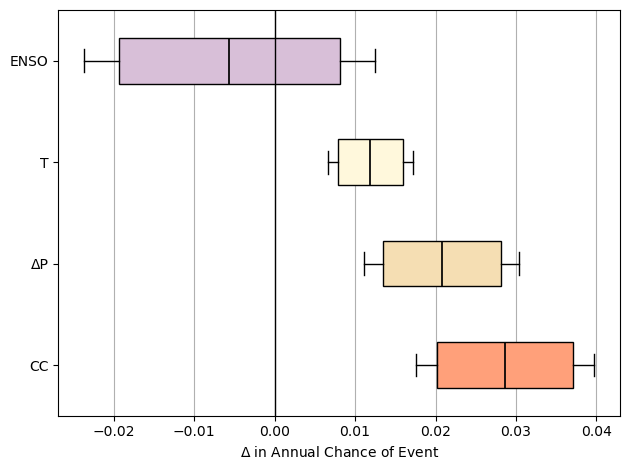

In [8]:
figure_3(model = flood_regression(df = df_flood))

In [9]:
def supplimental_create_boxes(model):    
    '''
    Creates boxes and whiskers from regression results. 
    '''
    betas, ci_95, ci_99 = model.params.to_dict(), model.conf_int(alpha=0.05).to_dict(), model.conf_int(alpha=0.01).to_dict()
    def namer(name: str):
        if name in ['t', 'cc', 'enso']:
            return str.upper(name)
        elif name == 'p_mean':
            return '\u0394' + 'P'
        elif name == 'Intercept':
            return 'Baseline (' + '\u03B2' + '\u2080' + ')'
        else:
            raise ValueError('Invalid {name}')
    boxes = []
    #for k in ['Intercept', 'cc', 'p_mean', 't', 'enso']:
    for k in ['cc', 't']:
        boxes.append(
            {
                'med': betas[k],
                'label': namer(k), 
                'q1': ci_95[0][k],
                'q3': ci_95[1][k],
                'whislo': ci_99[0][k],
                'whishi': ci_99[1][k],   
            }
        )
    return boxes

def supplimental_figure_TD(model):
    _, ax = plt.subplots() # figsize=(15,5)
    colors = ['lightsalmon', 'wheat']
    #colors = ['whitesmoke', 'lightsalmon', 'wheat', 'cornsilk', 'thistle']
    boxplot = ax.bxp(supplimental_create_boxes(model), patch_artist=True, boxprops=dict(linewidth=1), medianprops=dict(color='black', linewidth=1.25), showfliers=False, vert=False)
    for patch, color in zip(boxplot['boxes'], colors):
                patch.set_facecolor(color)
    ax.xaxis.grid(True)
    ymin, ymax = ax.get_ylim()
    ax.vlines(0, ymin, ymax, color='black', linewidth=1)
    plt.xlabel(r'$\Delta$ in Annual Chance of Event')
    plt.tight_layout()
    plt.show()

### Figure 4. Response Surface

In [10]:
def flood_response_surface_matrices(df) -> List[np.ndarray]:
    '''
    Returns list of numpy arrays with increases in annual frequency of flooding for [temperature x cc scaling, temperature x p_mean] scenarios.  
    '''
    t, cc, pm  = [0, 2, 3, 4], [0, 1, 2], [-1, 0, 1]
    txcc, txpm = np.empty((4, 3)), np.empty((4, 3))
    base = df.loc[(df['t'] == 0) & (df['cc'] == 0) & (df['p_mean'] == 0) & (df['enso'] == 0)]['flood'].to_numpy()[0]
    for i in range(0, len(t)):
        for j in range(0, len(cc)):
            txcc[i, j] = (df.loc[(df['t'] == t[i]) & (df['cc'] == cc[j]) & (df['p_mean'] == 0) & (df['enso'] == 0)]['flood'] - base) / base
            txpm[i, j] = (df.loc[(df['t'] == t[i]) & (df['cc'] == 0) & (df['p_mean'] == pm[j]) & (df['enso'] == 0)]['flood'] - base) / base
    return [txcc, txpm]

In [11]:
def figure_4(matrices: List[np.ndarray]):
    fig, axs = plt.subplots(ncols=len(matrices), sharey=True)
    colormap = LinearSegmentedColormap.from_list('', ['green', 'white', 'orange', 'orangered', 'maroon'])
    titles, xlabels, xticklabels = [r'$\bf{a}$', r'$\bf{b}$'], ['CC', r'$\Delta$P'], [['0', '1', '2'], ['-3%', 'no change', '+3%']]
    
    for i in range(0, len(matrices)):
        im = axs[i].imshow(matrices[i], cmap=colormap, vmin=-1, vmax=3, interpolation='bilinear')
        for (y, x), label in np.ndenumerate(matrices[i]):
            txt = axs[i].text(x, y, np.round(label, 1), ha='center', va='center')
            txt.set_bbox(dict(facecolor='white', edgecolor='None', alpha=0.25))
        axs[i].set_title(titles[i], loc='left')
        if i == 0:
            axs[i].set_ylabel(r'T ($^{\circ}$C)')
        axs[i].set_yticks([0, 1, 2, 3])
        axs[i].set_yticklabels(['0', '2', '3', '4'])
        axs[i].set_xlabel(xlabels[i]) 
        axs[i].set_xticks([0, 1, 2])
        axs[i].set_xticklabels(xticklabels[i])
    
    fig.subplots_adjust(right=0.85)
    ax_cbar = fig.add_axes([0.88, 0.18, 0.05, 0.65])
    cbar = plt.colorbar(im, cax=ax_cbar, label=r'$\Delta$ |Flood Events| / |Baseline Flood Events|')
    cbar.set_ticks([-1.0, 0.0, 1, 2, 3])
    plt.show()

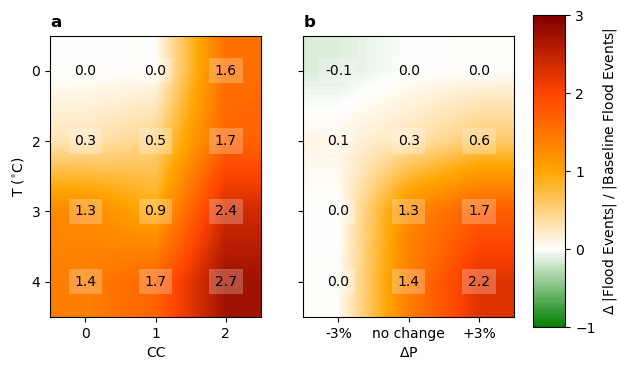

In [12]:
figure_4(flood_response_surface_matrices(df_flood))

In [13]:
def revised_figure_4(matrices: List[np.ndarray]):
    fig, axs = plt.subplots(ncols=len(matrices), sharey=True)
    colormap = LinearSegmentedColormap.from_list('', ['blue', 'white', 'orange', 'orangered', 'maroon'])
    titles, xlabels, xticklabels = [r'$\bf{a}$', r'$\bf{b}$'], ['CC', r'$\Delta$P'], [['0', '1', '2'], ['-3%', 'no change', '+3%']]
    
    for i in range(0, len(matrices)):
        im = axs[i].imshow(matrices[i], cmap=colormap, vmin=-1, vmax=3) # , interpolation='bilinear'
        for (y, x), label in np.ndenumerate(matrices[i]):
            txt = axs[i].text(x, y, np.round(label, 1), ha='center', va='center')
            txt.set_bbox(dict(facecolor='white', edgecolor='None', alpha=0.25))
        axs[i].set_title(titles[i], loc='left')
        if i == 0:
            axs[i].set_ylabel(r'T ($^{\circ}$C)')
        axs[i].set_yticks([0, 1, 2, 3])
        axs[i].set_yticklabels(['0', '2', '3', '4'])
        axs[i].set_xlabel(xlabels[i]) 
        axs[i].set_xticks([0, 1, 2])
        axs[i].set_xticklabels(xticklabels[i])
    
    fig.subplots_adjust(right=0.85)
    ax_cbar = fig.add_axes([0.88, 0.18, 0.05, 0.65])
    cbar = plt.colorbar(im, cax=ax_cbar, label=r'$\Delta$ |Flood Events| / |Baseline Flood Events|')
    cbar.set_ticks([-1.0, 0.0, 1, 2, 3])
    plt.show()

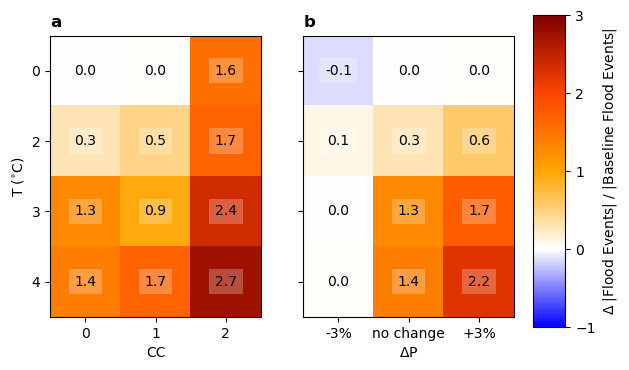

In [14]:
revised_figure_4(flood_response_surface_matrices(df_flood))

### Figure 5. Kernel Density

The following blocks of code are used to identify flood events in the simulated data.

In [15]:
def dsowy(dates):
    '''
    Converts list of datetimes to list integer day in water year values.
    '''
    days = []
    for d in dates:
        if d.is_leap_year:
            day = d.dayofyear - 274 if d.dayofyear > 274 else d.dayofyear + 91
        else:
            day = d.dayofyear - 273 if d.dayofyear > 273 else d.dayofyear + 91
        days.append(day)
    return days

In [16]:
class ThresholdType(Enum):
    MIN = 0
    '''Threshold value is minimum value for threshold'''
    MAX = 1
    '''Threshold value is maximum value for threshold'''

@dataclass
class Events:
    '''Dataclass for defining events in simulation data'''
    name: str = 'tuolumnehandoff' 
    '''Threshold column name'''
    threshold: float = 9000
    '''Threshold value'''
    threshold_type: ThresholdType = ThresholdType.MIN
    '''Type of threshold value'''
    window: Tuple[int, int] = (-28, 7)
    '''Number of days below threshold'''
    
    def scenario(self, df: pd.DataFrame, scenarioID: int, outpath: str = '') -> pd.DataFrame:
        '''For a given scenario constructs a dataframe containing: [scenario number, simulation numbers, start date, finish date, peak date] of events.'''
        dfs = [self.simulation(df[(df.scenario == scenarioID) & (df.sim == sim)].copy(deep=True)) for sim in df.sim.unique()]
        tmp = pd.concat(dfs)
        if outpath: tmp.to_csv(outpath)       
        return tmp
    
    def simulation(self, df: pd.DataFrame) -> pd.DataFrame:
        '''Identifies events in a given simulation level dataframe.'''
        # set up dictionary containing final dataframe
        events: Dict[str, List[dt.datetime]] = {'scenario': [], 'sim': [], 'peak': [], 'start': [], 'finish': []}
        df['date_sim'] = pd.to_datetime(df['date_sim'], yearfirst=True)
        df.set_index('date_sim', inplace=True, verify_integrity=True)
        # identify all the days over threshold value
        pds = df[df[self.name] > self.threshold].copy(deep=True)
        for date in pds.index.to_numpy():
            # is the day over threshold is part of a new event
            if self.isnewevent(date, events):
                # identify start, finish and peak of new event
                peak, start, finish = self.eventdates(date, df)
                events['peak'].append(peak)
                events['start'].append(start)
                events['finish'].append(finish)
                events['scenario'].append(df['scenario'].iloc[0])
                events['sim'].append(df['sim'].iloc[0])
        return pd.DataFrame.from_dict(events).astype({'sim': int, 'scenario': int})
    
    def isnewevent(self, date: dt.datetime, events: Dict[str, List[dt.datetime]]) -> bool:
        '''Identifies if a date falls within other known events windows.'''
        if events: # are there are events in the events dictionary
            for i in range(len(events['peak'])): # loop over events
                if events['start'][i] < date < events['finish'][i]: 
                    return False # date is in another event window 
        return True # first event or not in another event's window
    
    def eventdates(self, date: dt.datetime, df: pd.DataFrame) -> Tuple[dt.datetime, dt.datetime, dt.datetime]:
        '''Identifies the start, finish and peak dates of events around a given date.'''
        # start by assuming peak is date (day over threshold)
        peak = df.loc[date, self.name]
        #  dn = days before event without threshold exceedance, 
        # ndn = days before date, 
        #  up = days after event without threshold exceedance,
        # nup = days after date,
        #  pk = day of peak as offset from date 
        dn, ndn, up, nup, pk = -1, -1, 1, 1, 0
        # until the entire window around the event is IDd
        while dn > self.window[0] or up < self.window[1]:
            # window before hasn't been fully identified
            if dn > self.window[0]:
                day = date + pd.Timedelta(ndn, unit='d')
                val = df.loc[day, self.name]
                # day is over threhold (>min or <max)
                if self.isoverthreshold(val): 
                    dn = 0  # reset lower window counter        
                    if self.isnewpeak(peak, val):  
                        pk = ndn  # reset peak date offset
                        peak = df.loc[day, self.name] # set new peak value
                else: # value not over threshold
                    dn = dn - 1 # increment window counter
                # until lower window is identified increment to next day to anaylze
                ndn = ndn - 1 
            # window after hasn't been fully identified
            if up < self.window[1]:
                day = date + pd.Timedelta(ndn, unit='d')
                val = df.loc[day, self.name]
                # day is over threhold (>min or <max)
                if self.isoverthreshold(val): 
                    up = 0 # reset upper window counter
                    if self.isnewpeak(peak, val):  # if the val is above peak value
                        pk = nup # reset peak date offset
                        peak = df.loc[day, self.name] # set new peak value
                else: # value not over threshold
                    up = up + 1 # increment window counter
                # until upper window is identified increment to next day to analyze
                nup = nup + 1
        return date + pd.Timedelta(pk, unit='d'), date + pd.Timedelta(ndn, unit='d'), date + pd.Timedelta(nup, unit='d')

    def isoverthreshold(self, val: float):
        if self.threshold_type == ThresholdType.MIN:
            return True if self.threshold < val else False
        else: #self.thrshold_type == ThresholdType.MAX
            return True if self.threshold > val else False
    
    def isnewpeak(self, peak: float, val: float):
        if self.threshold_type == ThresholdType.MIN:
            return True if val > peak else False
        else: #self.thrshold_type == ThresholdType.MAX
            return True if val < peak else False

In [17]:
def identify_flood_events(scenarios: List[int]) -> List[pd.DataFrame]:
    '''
    Returns list of dataframes containing flood events, with one dataframe for each scenario.
    '''
    dfs = []
    floods = Events()
    for s in scenarios:
        df_sevents = floods.scenario(df=pd.read_csv(wat_1dy), scenarioID=s)
        df_sevents = df_sevents.merge(pd.read_csv(scenario_list), on=['scenario'], how='inner')
        df_sevents['dowy'] = dsowy(pd.to_datetime(df_sevents['peak']))
        dfs.append(df_sevents)
    return dfs

In [18]:
flood_events = identify_flood_events(scenarios=[i for i in range(1, 33, 1)])

In [19]:
def column_selector(df):
    if df['cc'].to_numpy()[0] == 0 and df['p_mean'].to_numpy()[0] == 0:
        return [0, 1]
    else:
        if df['cc'].to_numpy()[0] > 0 and df['p_mean'].to_numpy()[0] == 0:
            return [0]
        if df['cc'].to_numpy()[0] == 0 and df['p_mean'].to_numpy()[0] != 0:
            return [1]
        return None # interactions : cc x p_mean

In [20]:
def figure_5(dfs: List[pd.DataFrame]):
    colors = ['grey', '', 'orange', 'orangered', 'maroon']
    mosiac = [['top', 'top'],
              ['top', 'top'],
              ['top', 'top'], 
              ['00', '01'], 
              ['10', '11'], 
              ['20', '21'],
              ['30', '31']]
    fig, axs = plt.subplot_mosaic(mosaic=mosiac, sharex=True, sharey=True, figsize=(10,10), layout='constrained')
    for df in dfs:
        if df is None: continue
        row, col = 0 if df['t'].to_numpy()[0] == 0 else df['t'].to_numpy()[0] - 1, column_selector(df)
        sns.kdeplot(df['dowy'], ax=axs['top'], color=colors[df['t'].to_numpy()[0]])
        if col is None: continue
        for c in col:
            def deltaP_text(p):
                return '-3%' if p<0 else 0 if p==0 else '+3%'
            text = f"CC={df['cc'].to_numpy()[0]}" if c == 0 else (r"$\Delta$P="+f"{deltaP_text(df['p_mean'].to_numpy()[0])}")
            sns.kdeplot(df['dowy'], ax=axs[str(row)+str(c)], color=colors[df['t'].to_numpy()[0]], label=text)
    for k in axs:
        axs[k].set_ylim(0, 0.0150)
        axs[k].fill_between([0, 183], axs[k].get_ylim()[0], axs[k].get_ylim()[1], color='lightskyblue', alpha=0.25)
        axs[k].set_xlabel('')
        axs[k].set_xticks([0, 92, 183, 274, 365])
        axs[k].set_xticklabels(['1 Oct', '1 Jan', '1 Apr', '1 Jul', '30 Sep'])
        axs[k].set_ylabel('')
        axs[k].set_yticks([0.005, 0.010])      
        if k != 'top': labelLines(axs[k].get_lines(), zorder=2.5)
    for id, ax in axs.items():
        def id_to_label(id):
            if id == 'top':
                return 'a'
            elif id == '00':
                return 'b'
            elif id == '01':
                return 'f'
            elif id == '10':
                return 'c'
            elif id == '11':
                return 'g'
            elif id == '20':
                return 'd'
            elif id == '21':
                return 'h'
            elif id == '30':
                return 'e'
            elif id == '31':
                return 'i'
            else:
                raise KeyError(id)
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, id_to_label(id), transform=ax.transAxes + trans, verticalalignment='top', fontsize='medium', fontweight='bold')
    
    lines = []
    for i in range(0, len(colors)):
        if colors[i]: lines.append(Line2D([0], [0], color=colors[i], label=f'+{i}'+r'$^{\circ}C$'))
    lines.append(Patch(facecolor='lightskyblue', label='cold season'))
    axs['top'].legend(handles=lines, frameon=False)
    axs['top'].set_title('All scenarios')
    axs['00'].set_title('CC scenarios')
    axs['01'].set_title(r'$\Delta$P scenarios')
    fig.text(-0.02, 0.50, 'Density', rotation='vertical')
    fig.suptitle('Kernel Density of Date of Flood Occurance by Climate Scenario')
    plt.show()

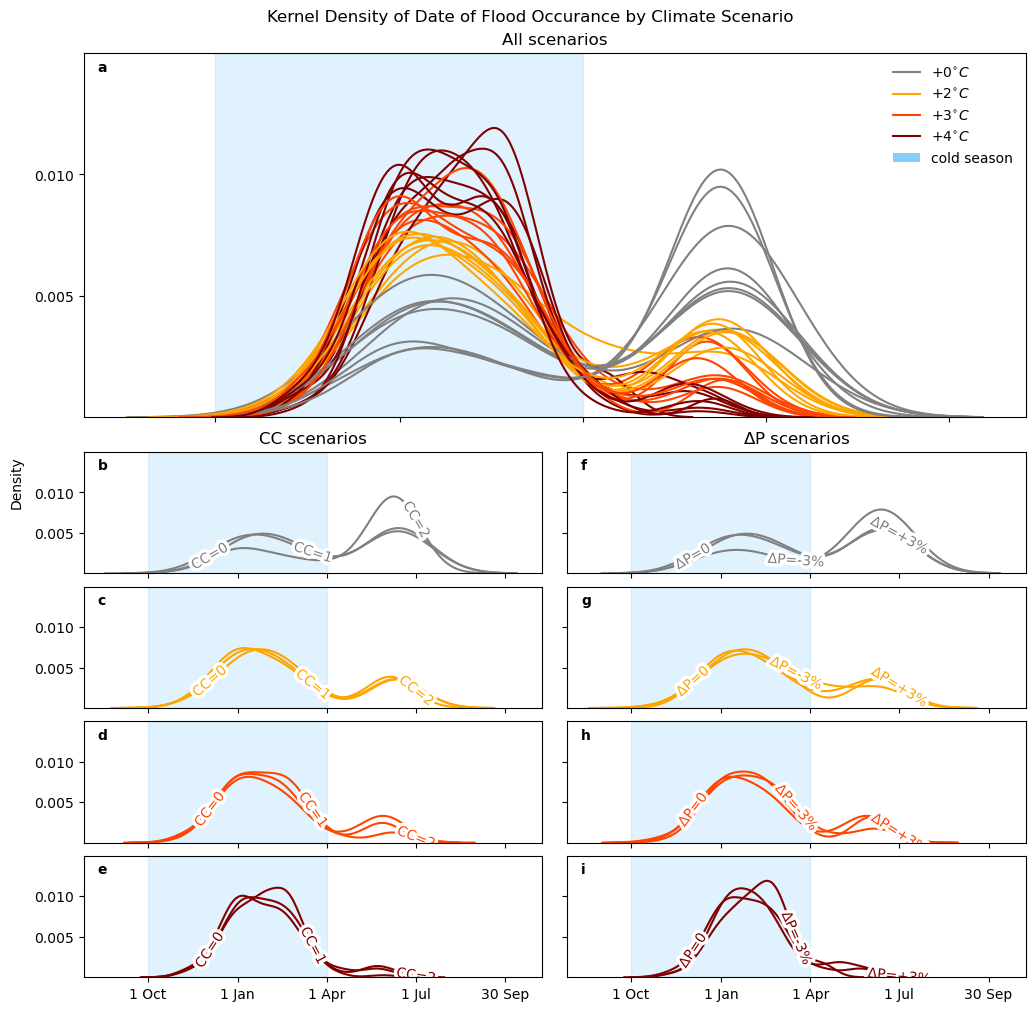

In [21]:
figure_5(dfs=flood_events)

In [22]:
def revised_figure_5(dfs: List[pd.DataFrame]):
    colors = ['grey', '', 'orange', 'orangered', 'maroon']
    mosiac = [['top', 'top'],
              ['top', 'top'],
              ['top', 'top'], 
              ['00', '01'], 
              ['10', '11'], 
              ['20', '21'],
              ['30', '31']]
    fig, axs = plt.subplot_mosaic(mosaic=mosiac, sharex=True, sharey=True, figsize=(10,10), layout='constrained')
    for df in dfs:
        if df is None: continue
        row, col = 0 if df['t'].to_numpy()[0] == 0 else df['t'].to_numpy()[0] - 1, column_selector(df)
        sns.kdeplot(df['dowy'], ax=axs['top'], color=colors[df['t'].to_numpy()[0]])
        if col is None: continue
        for c in col:
            def deltaP_text(p):
                return '-3%' if p<0 else 0 if p==0 else '+3%'
            text = f"CC={df['cc'].to_numpy()[0]}" if c == 0 else (r"$\Delta$P="+f"{deltaP_text(df['p_mean'].to_numpy()[0])}")
            sns.kdeplot(df['dowy'], ax=axs[str(row)+str(c)], color=colors[df['t'].to_numpy()[0]], label=text)
    for k in axs:
        axs[k].set_ylim(0, 0.0150)
        axs[k].fill_between([0, 183], axs[k].get_ylim()[0], axs[k].get_ylim()[1], color='lightskyblue', alpha=0.25)
        axs[k].set_xlabel('')
        axs[k].set_xticks([0, 92, 183, 274, 365])
        axs[k].set_xticklabels(['1 Oct', '1 Jan', '1 Apr', '1 Jul', '30 Sep'])
        axs[k].set_ylabel('')
        axs[k].set_yticks([0.005, 0.010])      
        if k != 'top': labelLines(axs[k].get_lines(), zorder=2.5)
    for id, ax in axs.items():
        def id_to_label(id):
            if id == 'top':
                return 'a'
            elif id == '00':
                return 'b'
            elif id == '01':
                return 'f'
            elif id == '10':
                return 'c'
            elif id == '11':
                return 'g'
            elif id == '20':
                return 'd'
            elif id == '21':
                return 'h'
            elif id == '30':
                return 'e'
            elif id == '31':
                return 'i'
            else:
                raise KeyError(id)
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, id_to_label(id), transform=ax.transAxes + trans, verticalalignment='top', fontsize='medium', fontweight='bold')
    
    lines = []
    for i in range(0, len(colors)):
        if colors[i]: lines.append(Line2D([0], [0], color=colors[i], label=f'+{i}'+r'$^{\circ}C$'))
    lines.append(Patch(facecolor='lightskyblue', label='cold season'))
    axs['top'].xaxis.set_tick_params(labelbottom=True)
    axs['top'].legend(handles=lines, frameon=False)
    axs['top'].set_title('All scenarios')
    axs['00'].set_title('CC scenarios')
    axs['01'].set_title(r'$\Delta$P scenarios')
    fig.text(-0.02, 0.50, 'Density', rotation='vertical')
    fig.suptitle('Kernel Density of Date of Flood Occurance by Climate Scenario')
    plt.show()

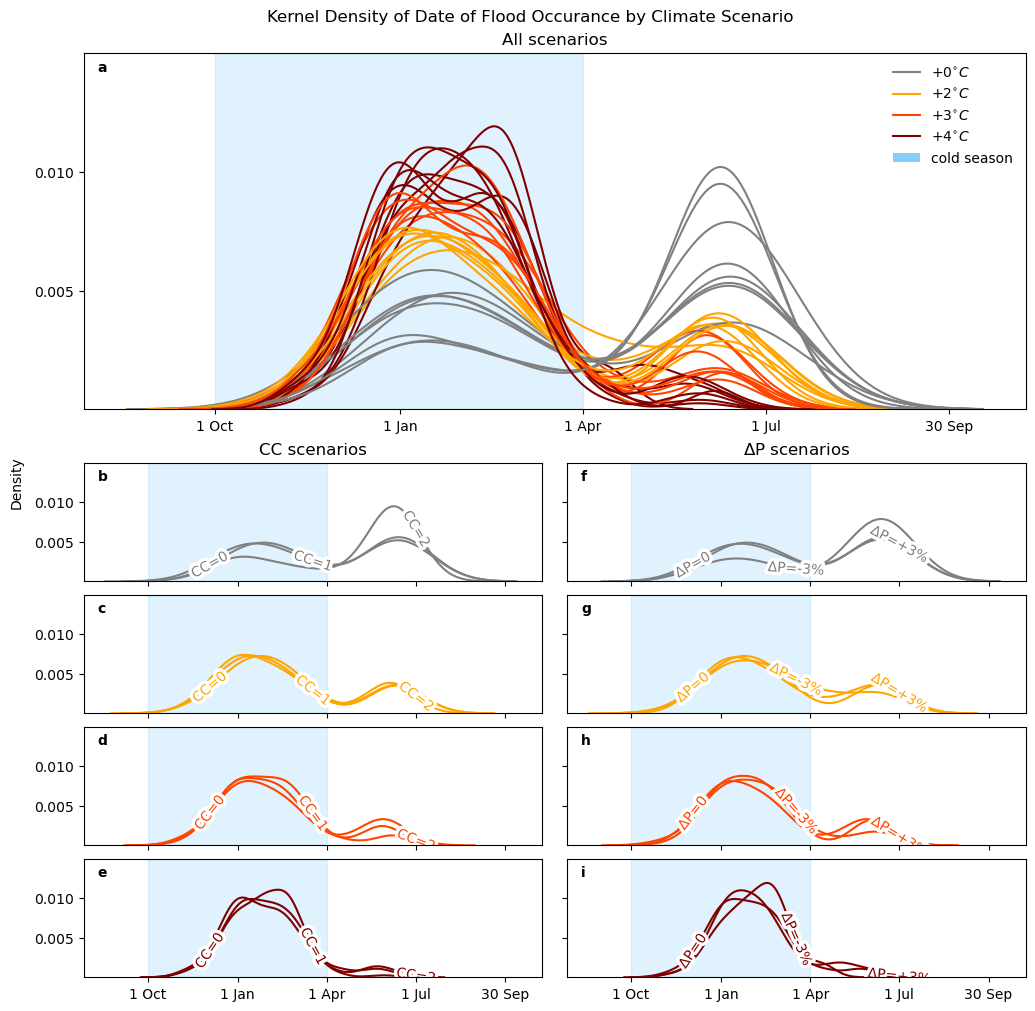

In [23]:
revised_figure_5(dfs=flood_events)

## Drought Figures

Data for plots 7b, 7c. Further processed to produce data for figure 6 and plot 7d. 

In [24]:
def droughts_monthly(df: pd.DataFrame):
    '''
    Returns monthly timeseries with droughts identified.
    '''
    dfs = []
    sims = sorted(df['sim'].unique())
    scenarios = sorted(df['scenario'].unique())
    for i in range(0, len(scenarios)):
        for j in range(0, len(sims)):
            df_s = filter(df, scenarios[i], sims[j])
            df_s['date_sim'] = pd.to_datetime(df_s['date_sim'])
            df_s.set_index('date_sim', inplace=True)
            df_s['wy'] = df_s.index.to_series().apply(lambda x: x.year + 1 if x.month > 9 else x.year)
            drought_id, level, length = find_droughts(s_ft=df_s['s_ft'].to_numpy())
            df_s['drought_id'] = drought_id
            df_s['drought_level'] = level
            df_s['drought_length'] = length
            df_s.reset_index(inplace=True)
            dfs.append(df_s) 
    return pd.concat(dfs)

def find_droughts(s_ft, threshold=800, duration=18, depths=[755, 750, 692], starting_id=1):
    '''
    Identifies droughts in monthly data, based on level 3 criteria: storage < 800ft for at least 18 months, with minimum storage < 692ft.
    '''
    is_deficit = False
    cnt, length, level = starting_id-1, 0, 0
    drought_id, drought_level, drought_length = np.zeros(len(s_ft),int), np.zeros(len(s_ft),int), np.zeros(len(s_ft),int)
    for i in range(0, len(s_ft)):
        if is_deficit:
            if s_ft[i] < threshold:
                length += 1
            else:
                start = i - length
                depth = min(s_ft[start: i])
                level = np.sum([1 if depth < x else 0 for x in depths]) # drought class
                if 0 < level and duration <= length: # is drought
                    cnt += 1
                    drought_id[start: i] = cnt
                    drought_level[start: i] = level
                    drought_length[start: i] = np.arange(1, length+1, 1)
                is_deficit = False    
        else:
            if s_ft[i] < threshold:
                length = 1
                is_deficit = True 
    return drought_id, drought_level, drought_length
    

In [25]:
df_monthly = droughts_monthly(pd.read_csv(wat_1mo))

Data for plots 7d, 8b.

In [26]:
def droughts_yearly(df_m: pd.DataFrame = df_monthly):
    '''
    Returns monthly drought timeseries aggregated to annual timeseries.
    '''
    df_m.sort_values(['scenario', 'sim', 'date_sim', 'wy'], inplace=True)
    df_yr = df_m.groupby(['scenario', 'sim', 'wy']).agg(
        {
        'qin_taf': 'sum',
        't': 'mean', 'cc': 'mean', 'p_mean': 'mean', 'enso': 'mean',
        'drought_id': 'last', 'drought_level': 'last', 'drought_length': 'max'
        })
    df_yr.reset_index(inplace=True)
    return df_yr

In [27]:
df_yearly = droughts_yearly(df_m = df_monthly)

Data for figure 6. Used to generate data for plot 7a.

In [28]:
def drought_years(df_m: pd.DataFrame = df_monthly):    
    '''
    Returns dataframe with count of drought years by scenario.
    '''
    # identify simulated years with droughts
    df = df_m[['scenario', 'sim', 'wy', 'drought_level']].drop_duplicates()
    i = 0
    was_drought = False
    keep = np.zeros(len(df), int)
    for row in df.itertuples():
        if was_drought:
            if row.drought_level > 0:   # drought continues
                keep[i-1] = 1           # last year was either start of drought or middle of drought.
            else:                       # drought ends
                keep[i-1] = 0           # drought ended last year                
        was_drought = row.drought_level > 0
        i+=1
    df['keep'] = keep
    df.sort_values(['scenario', 'sim', 'wy', 'keep', 'drought_level'],
                   ascending=[True, True, True, True, False], inplace=True)
    df.drop_duplicates(subset=['scenario', 'sim', 'wy'], keep='last', inplace=True) 
    df = df[['scenario','sim','wy','drought_level']]
    # count drought years by scenario {scenario: count}
    counts = {}
    scenarios = sorted(df['scenario'].unique())
    df = df[df['drought_level']==3]
    for i in range(0, len(scenarios)):
        df_s = filter(df, scenarios[i])
        counts[scenarios[i]] = len(df_s)
    # regression dataframe
    df = pd.DataFrame.from_dict(counts, orient='index', columns=[f'level3'])
    df[f'level3'] = df[f'level3'].astype('int') 
    df.index.rename('scenario', inplace=True)
    df_scenarios = pd.read_csv(scenario_list)
    df_scenarios.set_index('scenario', inplace=True)
    df = df_scenarios.merge(df, how='outer', left_index=True, right_index=True)
    df['p_mean'] = df['p_mean'].apply(lambda x: -1 if x == -0.03 else 0 if x == 0.0 else 1)
    return df[['t', 'enso', 'cc', 'p_mean', 'level3']]

In [29]:
df_drought = drought_years(df_monthly)

### Figure 6. Regression

In [30]:
def drought_regression(df):
    '''
    Regresses drought frequency on perturbation parameters.
    '''
    nyrs = (2051 - 2022) * 30   # (last wy - first wy) * nsims
    df['drought_frequency'] = df['level3'] / nyrs
    return smf.ols('drought_frequency~t+cc+p_mean+enso',df).fit(cov_type='HC1')

In [31]:
def figure_6(model):
    '''
    Exact copy of figure_3 function, calls create_boxes() from figure 3.
    '''
    _, ax = plt.subplots() # figsize=(15,5)
    #colors = ['whitesmoke', 'lightsalmon', 'wheat', 'cornsilk', 'thistle']
    colors = ['lightsalmon', 'wheat', 'cornsilk', 'thistle']
    boxplot = ax.bxp(create_boxes(model), patch_artist=True, boxprops=dict(linewidth=1), medianprops=dict(color='black', linewidth=1.25), showfliers=False, vert=False)
    for patch, color in zip(boxplot['boxes'], colors):
                patch.set_facecolor(color)
    ax.xaxis.grid(True)
    ymin, ymax = ax.get_ylim()
    ax.vlines(0, ymin, ymax, color='black', linewidth=1)
    plt.xlabel(r'$\Delta$ in Annual Chance of Event')
    plt.tight_layout()
    plt.show()

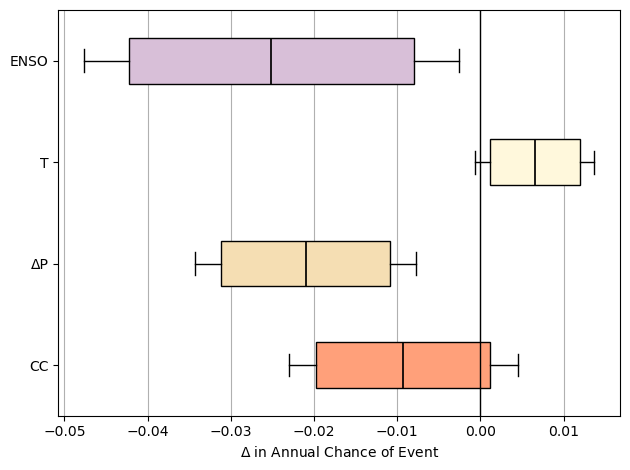

In [32]:
figure_6(model=drought_regression(df=df_drought))

### Figure 7. Drought-Temperature Plots

Data for plot 7a.

In [33]:
def drought_temperature_response_surface(df: pd.DataFrame = df_drought):
    '''
    Returns numpy array with increase in annual frequency of drought under temperature only scenarios.
    '''
    t = [0, 2, 3, 4]
    t_iso = np.empty(4)
    for i in range(0, len(t)):  
        t_iso[i] = df_drought.loc[(df_drought['t'] == t[i]) & (df_drought['cc'] == 0) & (df_drought['p_mean'] == 0) & (df_drought['enso'] == 0)]['level3'].to_numpy()[0]
    return (t_iso - t_iso[0]) / t_iso[0]
    

In [34]:
matrix_7a = drought_temperature_response_surface(df=df_drought).round(1)

In [35]:
def figure7(matrix,                 # a) response surface arguments
            df_m, scenarios, sim,   # b+c) storage + inflow plot arguments
            df_yr):                 # d) annual inflow
    layout =[
        ['a', 'b', 'b', 'b', 'd'],
        ['a', 'c', 'c', 'c', 'd']
    ]
    fig, axs = plt.subplot_mosaic(mosaic=layout, figsize=(15, 5), layout='constrained')
    
    # a) response surface
    colormap = LinearSegmentedColormap.from_list('', ['green', 'white', 'orange'])
    im = axs['a'].imshow(np.expand_dims(matrix, axis=1), cmap=colormap, vmin=-1, vmax=1, interpolation ='hanning')
    for yx, label in np.ndenumerate(matrix):
        txt = axs['a'].text(0, yx[0], label, ha='center', va='center')
        txt.set_bbox(dict(facecolor='white', edgecolor='None', alpha=0.25))
    cbar = plt.colorbar(im, ax=axs['a'], location='right', label=r'$\Delta$ |Drought Events| / |Baseline Drought Events|')
    cbar.set_ticks([-1.0, -0.5, 0.0, 0.5, 1])
    axs['a'].set_yticks([0, 1, 2, 3])
    axs['a'].set_yticklabels(['0', '2', '3', '4'])
    axs['a'].set_ylabel(r'T ($^\circ$C)')
    axs['a'].get_xaxis().set_ticks([])
    axs['a'].set_title('a', loc='left', fontweight='bold')
    
    # b, c) storage + inflow plot
    def seasonal_window(months=(4, 7), wys=(2021, 2052)):
        return [(pd.to_datetime(f'{wy}-{months[0]}-01'), pd.to_datetime(f'{wy}-{months[1]}-01'))
                if months[0] < 10 else
                (pd.to_datetime(f'{wy-1}-{months[0]}-01'), pd.to_datetime(f'{wy}-{months[1]}-01'))
                for wy in range(wys[0], wys[1])]  
    scenario_labels = ['', 'baseline', '+2C', '+3C', '+4C'] 
    scenario_colors = ['', 'grey', 'orange', 'orangered', 'maroon']
    winter, spring = seasonal_window((11, 4), (2021, 2052)), seasonal_window((4, 7), (2021, 2052))
    
    # b) storage component
    for i in range(0,len(scenarios)):
        df = filter(df_m, scenarios[i], sim)
        df.set_index('date_sim', inplace=True)
        axs['b'].plot(df.index, df['s_ft'].to_numpy(), color=scenario_colors[scenarios[i]], label=scenario_labels[scenarios[i]])
    for i in range(0, len(winter)):
        axs['b'].axvspan(winter[i][0], winter[i][1], color='aliceblue', label='_'*i + 'winter')
    for i in range(0, len(spring)):
        axs['b'].axvspan(spring[i][0], spring[i][1], color='papayawhip', label='_'*i + 'spring')
    
    axs['b'].hlines(800, xmin=df.index[0], xmax=df.index[-1], color='black', linestyles='dashed', alpha=0.1)    
    axs['b'].set_ylabel('Storage Elevation (ft)')    
    axs['b'].set_title('b', loc='left', fontweight='bold')
    plt.setp(axs['b'], xlim=(df.index[0], df.index[-1]))
    
    # c) inflow component
    for i in range(0,len(scenarios)):
        df = filter(df_m, scenarios[i], sim)
        df.set_index('date_sim', inplace=True)
        if scenarios[i] == 1:
            base_inflow = df['qin_taf'].to_numpy()
        axs['c'].step(df.index, (df['qin_taf'] - base_inflow), where='pre', color=scenario_colors[scenarios[i]], label=scenario_labels[scenarios[i]])
    for i in range(0, len(winter)):
        axs['c'].axvspan(winter[i][0], winter[i][1], color='aliceblue', label='_'*i + 'winter')
    for i in range(0, len(spring)):
        axs['c'].axvspan(spring[i][0], spring[i][1], color='papayawhip', label='_'*i + 'spring')
    
    axs['c'].set_ylabel(r'$\Delta$ Inflow (TAF m$^{-1}$)')
    axs['c'].set_title('c', loc='left', fontweight='bold')
    plt.setp(axs['c'], xlim=(df.index[0], df.index[-1]))
    
    # d) annual inflow 
    color_palette = {'1': 'grey', '2': 'orange', '3': 'orangered', '4': 'maroon'}
    df = pd.concat([filter(df_yr, s) for s in scenarios], axis=0)
    df['scenario'] = df['scenario'].astype(int)
    sns.boxplot(x=df['scenario'], y=df['qin_taf'], ax=axs['d'], showfliers=False, notch=True, palette=color_palette, boxprops=dict(alpha=0.75))
    axs['d'].set_xlabel(r'T ($^\circ$C)')
    axs['d'].set_ylabel('Inflow (TAF a$^{-1}$)')
    axs['d'].set_xticks([0, 1, 2, 3])
    axs['d'].set_xticklabels([0, 2, 3, 4])
    axs['d'].set_title('d', loc='left', fontweight='bold')


    legenditems = []
    for i in range(0, len(scenario_colors)):
        if scenario_colors[i]: legenditems.append(Line2D([0], [0], color=scenario_colors[i], label=f'+{i}'+r'$^{\circ}C$'))
    legenditems.append(Patch(facecolor='aliceblue', label='cold season'))
    legenditems.append(Patch(facecolor='papayawhip', label='spring'))
    fig.legend(handles=legenditems, loc='outside upper center', ncols=3, frameon=False)
    #fig.suptitle('Impact of Warming on Droughts', va='top', ha='left', fontweight='bold')
    plt.show()

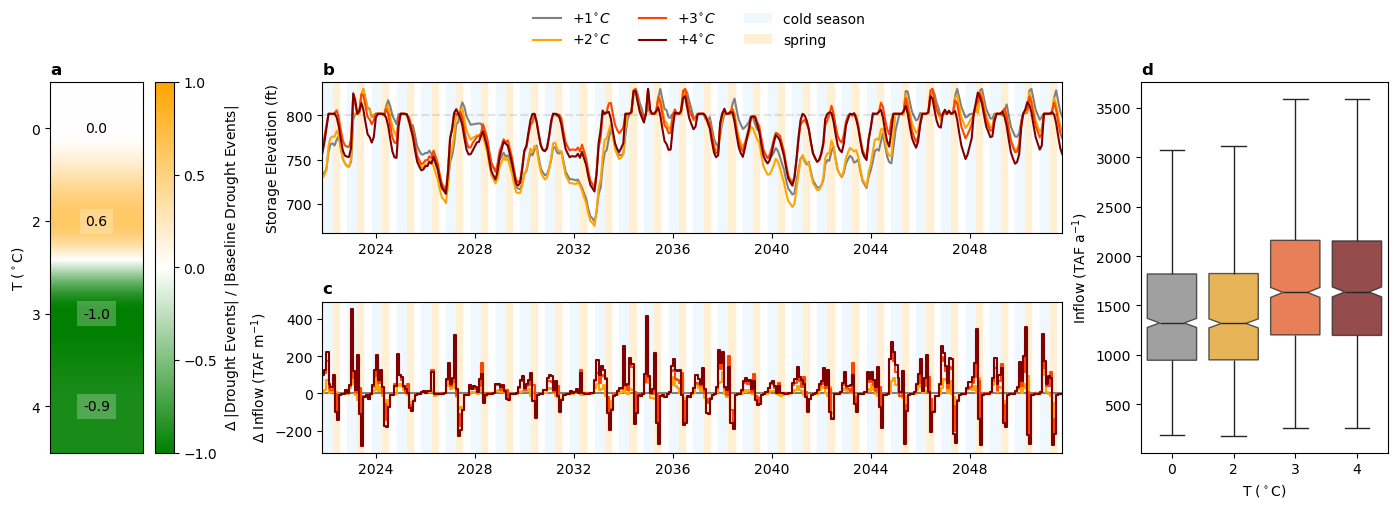

In [36]:
figure7(matrix_7a,   # a) response surface
        df_monthly, [1, 2, 3, 4], 71, # b) storage plot
        df_yearly)

In [37]:
def revised_figure7(matrix,                 # a) response surface arguments
            df_m, scenarios, sim,   # b+c) storage + inflow plot arguments
            df_yr):                 # d) annual inflow
    layout =[
        ['a', 'b', 'b', 'b', 'd'],
        ['a', 'c', 'c', 'c', 'd']
    ]
    fig, axs = plt.subplot_mosaic(mosaic=layout, figsize=(15, 5), layout='constrained')
    
    # a) response surface
    colormap = LinearSegmentedColormap.from_list('', ['green', 'white', 'orange'])
    im = axs['a'].imshow(np.expand_dims(matrix, axis=1), cmap=colormap, vmin=-1, vmax=1)
    for yx, label in np.ndenumerate(matrix):
        txt = axs['a'].text(0, yx[0], label, ha='center', va='center')
        txt.set_bbox(dict(facecolor='white', edgecolor='None', alpha=0.25))
    cbar = plt.colorbar(im, ax=axs['a'], location='right', label=r'$\Delta$ |Drought Events| / |Baseline Drought Events|')
    cbar.set_ticks([-1.0, -0.5, 0.0, 0.5, 1])
    axs['a'].set_yticks([0, 1, 2, 3])
    axs['a'].set_yticklabels(['0', '2', '3', '4'])
    axs['a'].set_ylabel(r'T ($^\circ$C)')
    axs['a'].get_xaxis().set_ticks([])
    axs['a'].set_title('a', loc='left', fontweight='bold')
    
    # b, c) storage + inflow plot
    def seasonal_window(months=(4, 7), wys=(2021, 2052)):
        return [(pd.to_datetime(f'{wy}-{months[0]}-01'), pd.to_datetime(f'{wy}-{months[1]}-01'))
                if months[0] < 10 else
                (pd.to_datetime(f'{wy-1}-{months[0]}-01'), pd.to_datetime(f'{wy}-{months[1]}-01'))
                for wy in range(wys[0], wys[1])]  
    scenario_labels = ['', 'baseline', '+2C', '+3C', '+4C'] 
    scenario_colors = ['', 'grey', 'orange', 'orangered', 'maroon']
    winter, spring = seasonal_window((11, 4), (2021, 2052)), seasonal_window((4, 7), (2021, 2052))
    
    # b) storage component
    for i in range(0,len(scenarios)):
        df = filter(df_m, scenarios[i], sim)
        df.set_index('date_sim', inplace=True)
        axs['b'].plot(df.index, df['s_ft'].to_numpy(), color=scenario_colors[scenarios[i]], label=scenario_labels[scenarios[i]])
    for i in range(0, len(winter)):
        axs['b'].axvspan(winter[i][0], winter[i][1], color='aliceblue', label='_'*i + 'winter')
    for i in range(0, len(spring)):
        axs['b'].axvspan(spring[i][0], spring[i][1], color='papayawhip', label='_'*i + 'spring')
    
    axs['b'].hlines(800, xmin=df.index[0], xmax=df.index[-1], color='black', linestyles='dashed', alpha=0.1)    
    axs['b'].set_ylabel('Storage Elevation (ft)')    
    axs['b'].set_title('b', loc='left', fontweight='bold')
    plt.setp(axs['b'], xlim=(df.index[0], df.index[-1]))
    
    # c) inflow component
    for i in range(0,len(scenarios)):
        df = filter(df_m, scenarios[i], sim)
        df.set_index('date_sim', inplace=True)
        if scenarios[i] == 1:
            base_inflow = df['qin_taf'].to_numpy()
        axs['c'].step(df.index, (df['qin_taf'] - base_inflow), where='pre', color=scenario_colors[scenarios[i]], label=scenario_labels[scenarios[i]])
    for i in range(0, len(winter)):
        axs['c'].axvspan(winter[i][0], winter[i][1], color='aliceblue', label='_'*i + 'winter')
    for i in range(0, len(spring)):
        axs['c'].axvspan(spring[i][0], spring[i][1], color='papayawhip', label='_'*i + 'spring')
    
    axs['c'].set_ylabel(r'$\Delta$ Inflow (TAF m$^{-1}$)')
    axs['c'].set_title('c', loc='left', fontweight='bold')
    plt.setp(axs['c'], xlim=(df.index[0], df.index[-1]))
    
    # d) annual inflow 
    color_palette = {'1': 'grey', '2': 'orange', '3': 'orangered', '4': 'maroon'}
    df = pd.concat([filter(df_yr, s) for s in scenarios], axis=0)
    df['scenario'] = df['scenario'].astype(int)
    sns.boxplot(x=df['scenario'], y=df['qin_taf'], ax=axs['d'], showfliers=False, notch=True, palette=color_palette, boxprops=dict(alpha=0.75))
    axs['d'].set_xlabel(r'T ($^\circ$C)')
    axs['d'].set_ylabel('Inflow (TAF a$^{-1}$)')
    axs['d'].set_xticks([0, 1, 2, 3])
    axs['d'].set_xticklabels([0, 2, 3, 4])
    axs['d'].set_title('d', loc='left', fontweight='bold')


    legenditems = []
    for i in range(0, len(scenario_colors)):
        if scenario_colors[i]: legenditems.append(Line2D([0], [0], color=scenario_colors[i], label=f'+{i}'+r'$^{\circ}C$'))
    legenditems.append(Patch(facecolor='aliceblue', label='cold season'))
    legenditems.append(Patch(facecolor='papayawhip', label='spring'))
    fig.legend(handles=legenditems, loc='outside upper center', ncols=3, frameon=False)
    #fig.suptitle('Impact of Warming on Droughts', va='top', ha='left', fontweight='bold')
    plt.show()

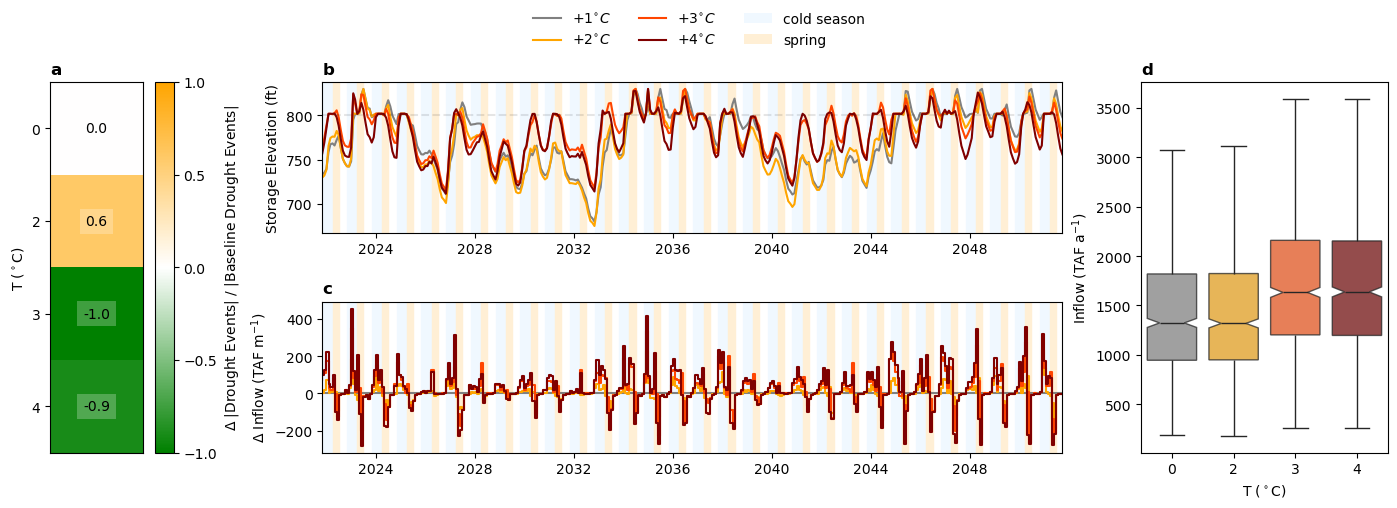

In [38]:
revised_figure7(matrix_7a,   # a) response surface
        df_monthly, [1, 2, 3, 4], 71, # b) storage plot
        df_yearly)

## Figure 8. ENSO

Data used for plot 8a

In [39]:
def anomoly(df, mean):
    '''
    Returns input dataframe with accumulated inflow anomoly column.
    '''
    i, last = 0, 0
    anomoly = np.zeros(len(df))
    for row in df.itertuples():
        anomoly[i] = (row.qin_taf - mean) + last
        last = anomoly[i]
        i+= 1
    df['anomoly'] = anomoly
    return df

def deficit(df, mean, level=1):           
    '''
    Returns input dataframe with accumulated inflow deficit column.
    '''
    i, last, = 0, 0
    is_drought = False
    new_ids = np.zeros(len(df), int)
    new_lvl = np.zeros(len(df), int)
    deficit = np.zeros(len(df), float)
    for row in df.itertuples():
        if row.drought_level >= level:
            new_ids[i] = row.drought_id
            new_lvl[i] = row.drought_level
            deficit[i] = (row.qin_taf - mean) + last
            last = deficit[i]
            is_drought = True
        else:
            if is_drought:
                new_ids[i] = new_ids[i-1]
                new_lvl[i] = new_lvl[i-1]
                deficit[i] = (row.qin_taf - mean) + last
                is_drought = False
                last = 0
        i += 1
    df['_id'] = new_ids
    df['_level'] = new_lvl
    df['deficit'] = deficit
    return df

def accumulated_fxs(df, mean=np.mean(filter(df_yearly, 1)['qin_taf'].to_numpy()), scenarios=[1, 37], fxs=[anomoly, deficit]):
    '''
    Returns input dataframe with accumulated anomoly and deficit columns.
    '''
    dfs = []
    sims = sorted(df['sim'].unique())
    for i in range(0, len(scenarios)):
        for j in range(0, len(sims)):
            df_s = filter(df, scenarios[i], sims[j])
            for fx in fxs:
                df_s = fx(df_s, mean)
            dfs.append(df_s)    
    return pd.concat(dfs)

In [40]:
df_anomolies = accumulated_fxs(df=df_yearly, mean=np.mean(filter(df_yearly, 1)['qin_taf'].to_numpy()), scenarios=[1, 37], fxs=[anomoly, deficit])

In [41]:
def max_deficit(df):
    df = df[df['drought_level'] >= 1]
    return df.loc[df.groupby(['scenario', 'sim', '_id']).deficit.idxmin()]

In [42]:
df_max_deficit = max_deficit(df_anomolies)
df_max_deficit.tail()

,scenario,sim,wy,qin_taf,t,cc,p_mean,enso,drought_id,drought_level,drought_length,anomoly,_id,_level,deficit
29625,37,89,2037,583.651723,0.0,0.0,0.0,1.0,2,2,15,8.175064,2,2,-744.603687
29638,37,89,2050,967.379440,0.0,0.0,0.0,1.0,3,2,29,4976.906635,3,2,-1378.001531
29645,37,94,2027,455.704768,0.0,0.0,0.0,1.0,1,2,12,788.698790,1,2,-975.132118
29652,37,94,2034,1372.649136,0.0,0.0,0.0,1.0,2,2,29,479.704885,2,2,-1251.943971
29661,37,94,2043,1361.664659,0.0,0.0,0.0,1.0,3,2,36,2799.072616,3,2,-1969.063638


Data for plot 8b

In [43]:
def day_of_water_year(date: str):
    '''
    Returns day of water year given a month-day string.
    '''
    m, d = int(date.split('-')[0]), int(date.split('-')[1])
    if m == 10:
        return d
    elif m ==11:
        return d + 31 
    elif m ==12:
        return d + 61
    elif m == 1:
        return d + 92
    elif m == 2:
        if d == 29:
            return -999
        return d + 123
    elif m == 3:
        return d + 151
    elif m == 4:
        return d + 182
    elif m == 5:
        return d + 212
    elif m == 6:
        return d + 243
    elif m == 7:
        return d + 273
    elif m == 8:
        return d + 304
    elif m == 9:
        return d + 335
    else:
        raise ValueError(f'month {m} is an error.')  

def moving_averages(df_1d: pd.DataFrame, scenarios: List[int], sims: List[int]):
    dfs = []
    for scenario in scenarios:
        first_sim = True
        df_scenario = None
        for sim in sims:
            df = filter(df_1d, scenario, sim)
            # clean up
            df['date_sim'] = pd.to_datetime(df['date_sim'])
            df = df[(df['date_sim'] >= '2021-10-01') & (df['date_sim'] <= '2051-09-30')]
            df.set_index('date_sim', inplace=True)
            df['date'] = df.index.strftime('%m-%d')
            df.sort_index(inplace=True)
            # Average for each day in simulated years
            #df['qin_af'] = df['qin_af'].rolling(window=30, min_periods=1).mean().to_numpy()
            df = df.groupby('date', as_index=False)['qin_af'].mean()
            df.set_index('date', inplace=True)
            df.sort_index(inplace=True)
            if first_sim: # first sim in scenario
                df_scenario = pd.DataFrame(index = df.index.copy(deep=True))
                first_sim = False
            # 30 day rolling average
            df_scenario[f'sim{sim}'] = df['qin_af'].rolling(window=30, min_periods=1).mean().to_numpy()
        mean = df_scenario.mean(axis=1)
        qs = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
        qvals = [df_scenario.quantile(q, axis = 1) for q in qs]
        df_scenario['scenario'] = scenario
        df_scenario['mean'] = mean
        for i in range(0, len(qvals)):
            df_scenario[qs[i]] = qvals[i]
        df_scenario['dowy'] = df.apply(lambda x: day_of_water_year(x.name), axis=1)
        df_scenario = df_scenario[df_scenario['dowy'] != -999]
        df_scenario.sort_values(by=['dowy'], inplace=True)
        dfs.append(df_scenario)
    return pd.concat(dfs, axis=0)

In [44]:
df_inflows = moving_averages(df_1d = pd.read_csv(wat_1dy), scenarios=[1, 37], sims=[1, 5, 11, 12, 14, 17, 18, 22, 32, 39, 43, 46, 50, 54, 55, 57, 58, 62, 65, 67, 70, 71, 75, 79, 81, 87, 88, 89, 94, 99])

In [45]:
def figure_8(anomolies, max_deficits, df_inflows):
    layout = [['a', 'a', 'b', 'c', 'c', 'c']]
    fig, axs = plt.subplot_mosaic(mosaic=layout, figsize=(15,5), layout='constrained')
    scenarios = [1, 37]
    colors=['grey', 'purple']
    
    # a) kde
    df = pd.concat([filter(anomolies, scenario) for scenario in scenarios]) # scenarios baseline, enso=1
    sns.kdeplot(data=df, ax=axs['a'], x='anomoly', hue='scenario', fill=True, palette=colors, legend=False)
    sns.scatterplot(data=max_deficits, ax=axs['a'], x='deficit', y=np.full(len(max_deficits['deficit']), 0.00010), hue='scenario', palette=['grey', 'thistle'], s=500, marker='|', alpha=0.5, legend=False)
    axs['a'].ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
    axs['a'].set_xlabel('Inflow Anomoly (MAF $a^{-1}$)')
    axs['a'].set_xticks([-10000, -5000, 0, 5000, 10000])
    axs['a'].set_xticklabels([-10, -5, 0, 5, 10])
    legenditems = [Patch(facecolor='grey', label='Baseline (anomoly)'),
                   Patch(facecolor='purple', label='2X ENSO (anomoly)'),
                   Line2D([], [], color='grey', marker='|', markersize=10, linestyle='None', label='Baseline (max deficit)'),
                   Line2D([], [], color='purple', marker='|', markersize=10, linestyle='None', label='2X ENSO (max deficit)')]
    axs['a'].legend(handles=legenditems, frameon=False, framealpha=1)
    
    # b) box plot
    color_palette = {'1': 'grey', '37': 'thistle'}
    df = pd.concat([filter(df_yearly, s) for s in scenarios], axis=0)
    df['scenario'] = df['scenario'].astype(int)
    sns.boxplot(x=df['scenario'], y=df['qin_taf']/1000, ax=axs['b'], showfliers=False, notch=True, palette=color_palette, boxprops=dict(alpha=0.75))
    axs['b'].set_xlabel('Scenario')
    axs['b'].set_ylabel('Inflow (MAF a$^{-1}$)')
    axs['b'].set_xticks([0, 1])
    axs['b'].set_xticklabels(['Baseline', '2X ENSO'])
    
    
    # b) timeseries
    xs = filter(df_inflows, 1)['dowy'].to_numpy()
    zero = np.zeros(len(xs))
    base = filter(df_inflows, 1)[0.5].to_numpy() 
    enso = filter(df_inflows, 37)[0.5].to_numpy() 
    axs['c'].plot(filter(df_inflows, 1)['dowy'].to_numpy(), base-enso, color='purple', label= '2X ENSO - Baseline')
    axs['c'].fill_between(xs, base-enso, where=(base-enso)>zero, color='honeydew')
    axs['c'].fill_between(xs, base-enso, where=(base-enso)<zero, color='mistyrose')
    axs['c'].set_xticks([1, 92, 182, 273, 365])
    axs['c'].set_xticklabels(['1 Oct', '1 Jan', '1 Apr', '1 Jul', '30 Sep'])
    axs['c'].set_ylabel(r'$\Delta$ in Inflow (AF d$^{-1}$)')
    axs['c'].legend(frameon=False, loc='upper center')

    for id, ax in axs.items():
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, id, transform=ax.transAxes + trans, verticalalignment='top', fontsize='medium', fontweight='bold')
    plt.show

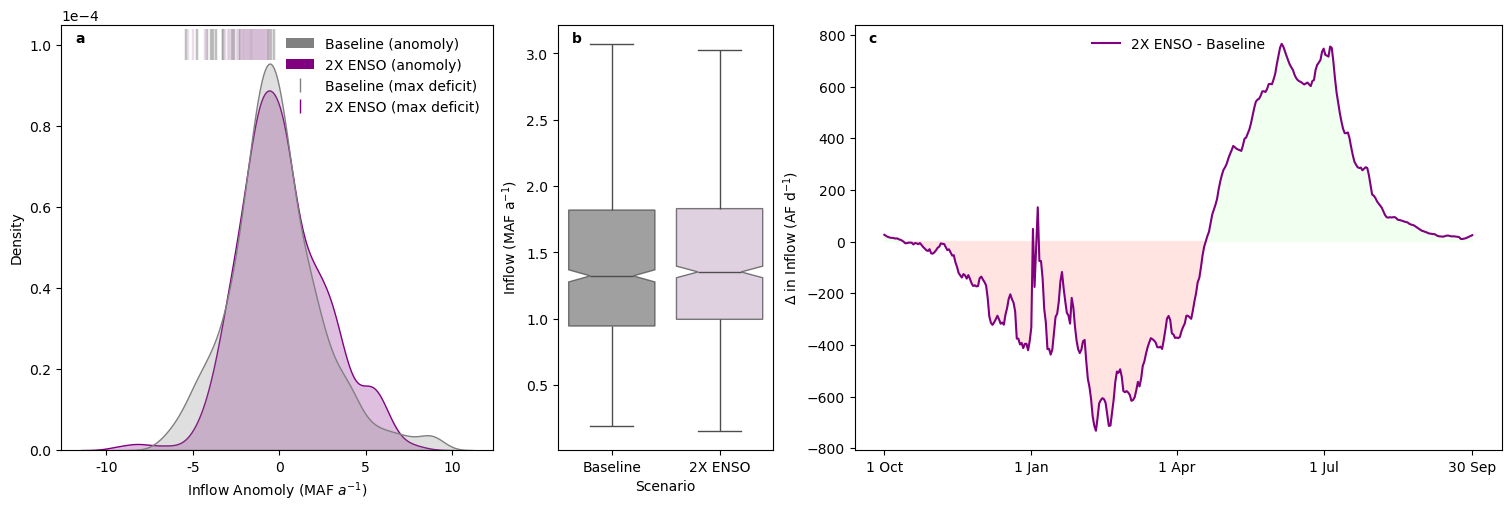

In [46]:
figure_8(anomolies=df_anomolies, max_deficits=df_max_deficit, df_inflows=df_inflows)

## Figure 9 & Supporting Materials.

In [47]:
scenario_groups = [
    [1, 18, 19, 20, 22, 23, 24],                    # TD : baseline, [-3,3]deltaP[2-4C] + 1xCC[2-4C] 
    [1, 2, 3, 4, 9, 10, 11, 12],                    # BU : baseline, [ 0,3]deltaP[0-4C]   
    [1, 2, 3, 4, 13, 14, 15, 16, 25, 26, 27, 28],   # HY1: baseline, [   0]deltaP[0-4C] + 1-2xCC[0-4C]
    np.arange(1, 13).tolist(),                      # HY2: baseline, [-3,3]deltaP[0-4C]
    np.arange(1, 33).tolist()                       # HYA: baseline, [-3,3]deltaP[0-4C] + 1-2CC[0-4C]
]
def sup_regression(df):
    '''
    Regresses flood frequency on perturbation parameters.
    '''
    return smf.ols('flood_frequency~t+p_scale',df).fit(cov_type='HC1')

def p_scale(t, cc, p_mean):
    if t == 0:
        return cc * 7 + p_mean * 3
    else:
        return (cc * 7 + p_mean * 3) * t

def supplimental_data(df_flood, scenario_groups):
    dfs = []
    for _, group in enumerate(scenario_groups):
        df = df_flood.loc[group]
        df['p_scale'] = df.apply(lambda row: p_scale(row.t, row.cc, row.p_mean), axis=1)
        df['y_hat'] = sup_regression(df).fittedvalues
        df['error'] = sup_regression(df).resid
        base = df.loc[1, 'flood_frequency']
        df['percent_change'] = (df['flood_frequency'] - base) / base * 100
        df['percent_change_hat'] = (df['y_hat'] - base) / base * 100
        dfs.append(df)
    return dfs

### Figure 9. Approach Comparision

In [48]:
def get_Z(XY, df, zlabel='percent_change'):
    x, y = np.ravel(XY[0]), np.ravel(XY[1])
    z = np.full(x.shape, np.nan)
    for i in range(0, len(x)):
        try:
            z[i] = df[(df['t'] == x[i]) & (df['p_scale'] == y[i])][zlabel].item()
        except ValueError:
            z[i] = np.nan
    return z.reshape(XY[0].shape)

def compute_Z(XY, params):
    x, y = np.ravel(XY[0]), np.ravel(XY[1])
    z = np.full(x.shape, np.nan)
    base = params.Intercept + params.t * 0 + params.p_scale * 0
    for i in range(0, len(x)):
        z[i] = ((params.Intercept + params.t * x[i] + params.p_scale * y[i]) - base) / base * 100
    return z.reshape(XY[0].shape)

def linear(vector):
    start, n = np.nan, 0
    for i, x in enumerate(vector):
        if np.isnan(x):
            # in sequence.
            if not np.isnan(start):
                n += 1
            # last item in vector, no value.
            if i + 1 == len(vector):
                # not empty vector.
                if not np.isnan(start) and start != 0.0:
                    vector[i-n+1] = 0
        else: # has value.
            # first value, nan previous values.
            if np.isnan(start) and i > 0:
                vector[i-1] = 0
            # beginning of sequence.
            if n == 0:
                start = x
                # print(f'start: {start}, i: {i}')
            # end of sequence.
            else:
                # print(f'x: {x}, start: {start} i: {i}, n: {n}')
                dx = (x - start) / (n + 1)
                epsilon = dx
                for k in range(n, 0, -1):
                    vector[i-k] = start + epsilon
                    epsilon += dx
                start, n = x, 0
    return vector

def interpolate(M):
    rows, cols = M.shape
    for col in range(0, cols):
        M[:, col] = linear(M[:, col])
    for row in range(0, rows):
        M[row, :] = linear(M[row, :])
    return M    

def figure_9(dfs):
    '''Compares:
    ~top-down: scenarios with  1xCC + [-3, 3]ΔP + [2, 4]ΔT
    ~bottom-up:scenarios with  noCC + [ 0, 3]ΔP + [0, 4]ΔT
    ~hybrid:   scenarios with 1-2CC + [ 0]ΔP + [0, 4]ΔT
    '''
    labels = [['a', 'b', 'c'], ['d', 'e', 'f']]
    #X, Y = np.meshgrid(np.array([0, 2, 3, 4]), np.arange(0, 60))  #np.meshgrid(np.arange(0, 5), np.arange(0, 60))
    fig, axs= plt.subplots(nrows=2, ncols=3, figsize=(15, 10), subplot_kw={'projection': '3d'}, tight_layout=True)
    for i, v in enumerate([0, 1, 2]):
        df = dfs[v]
        X, Y = np.meshgrid(df['t'].unique(), df['p_scale'].unique())

        # actual values
        Z = interpolate(get_Z((X, Y), df))
        Zmask = np.ma.masked_where(Z == 0, Z)
        
        axs[0, i].set(zlim=(0, 275), ylim=(-15, 60))
        axs[0, i].scatter(df['t'], df['p_scale'], df['percent_change'], c='black', marker='o')
        axs[0, i].plot_surface(X, Y, Zmask, edgecolor='whitesmoke', linewidths=0.5, alpha=0.5) # cmap='viridis',
        axs[0, i].contourf(X, Y, Z, zdir='z', offset=0, vmin=0, vmax=275, cmap='viridis')
        axs[0, i].set_xlabel('Warming (°C)', fontsize=9)
        axs[0, i].set_xticks([0, 2, 3, 4])
        axs[0, i].set_ylabel('Increase in Extreme\nPrecipitation (%Δ)', labelpad=7.0, fontsize=9)
        axs[0, i].set_zlabel('%Δ in Flood Frequency', fontsize=9)
        axs[0, i].set_box_aspect(None, zoom=0.85)
        axs[0, i].text2D(0.15, 0.75, labels[0][i], transform=axs[0, i].transAxes, fontsize=12, fontweight='bold') 
        
        # predicted values
        Zhat = interpolate(get_Z((X, Y), df, zlabel='percent_change_hat'))
        Zhat_mask = np.ma.masked_where(Zhat == 0, Zhat)
        # full range of predictions
        X_, Y_ = np.meshgrid(np.arange(0, 5), np.arange(0, 70))
        Zhatfull = compute_Z((X_, Y_), sup_regression(df).params)
        Zhatfull_mask = np.where(Zhatfull < 0, 0, Zhatfull)
        Zhatfull_mask = np.where(Zhatfull_mask > 275, 275, Zhatfull_mask)
        
        axs[1, i].set(zlim=(0, 275), ylim=(-15, 60))
        if labels[1][i] == 'd':
            cb = axs[1, i].contourf(X_, Y_, Zhatfull_mask, zdir='z', offset=-30, vmin=0, vmax=275, cmap='viridis')
        else:
            axs[1, i].contourf(X_, Y_, Zhatfull_mask, zdir='z', offset=-30, vmin=0, vmax=275, cmap='viridis')
        axs[1, i].plot_surface(X, Y, Zhat_mask, edgecolor='whitesmoke', linewidths=0.5, alpha=0.5) #cmap='viridis', 
        axs[1, i].scatter(df['t'], df['p_scale'], df['percent_change_hat'], c='black', marker='o')
        axs[1, i].set_xlabel('Warming (°C)', fontsize=9)
        axs[1, i].set_xticks([0, 2, 3, 4])
        axs[1, i].set_ylabel('Increase in Extreme\nPrecipitation (%Δ)', labelpad=7.0, fontsize=9)
        axs[1, i].set_zlabel('%Δ in Flood Frequency', fontsize=9)
        axs[1, i].set_box_aspect(None, zoom=0.85)
        axs[1, i].text2D(0.15, 0.75, labels[1][i], transform=axs[1, i].transAxes, fontsize=12, fontweight='bold')
    
    ax_cbar = fig.add_axes([0.1, -0.02, 0.8, 0.03])
    fig.colorbar(cb, cax=ax_cbar, orientation='horizontal', label='%Δ in Flood Frequency')      
    plt.show()

/Users/rdel1jrk/miniconda3/envs/tuolumne-paper/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


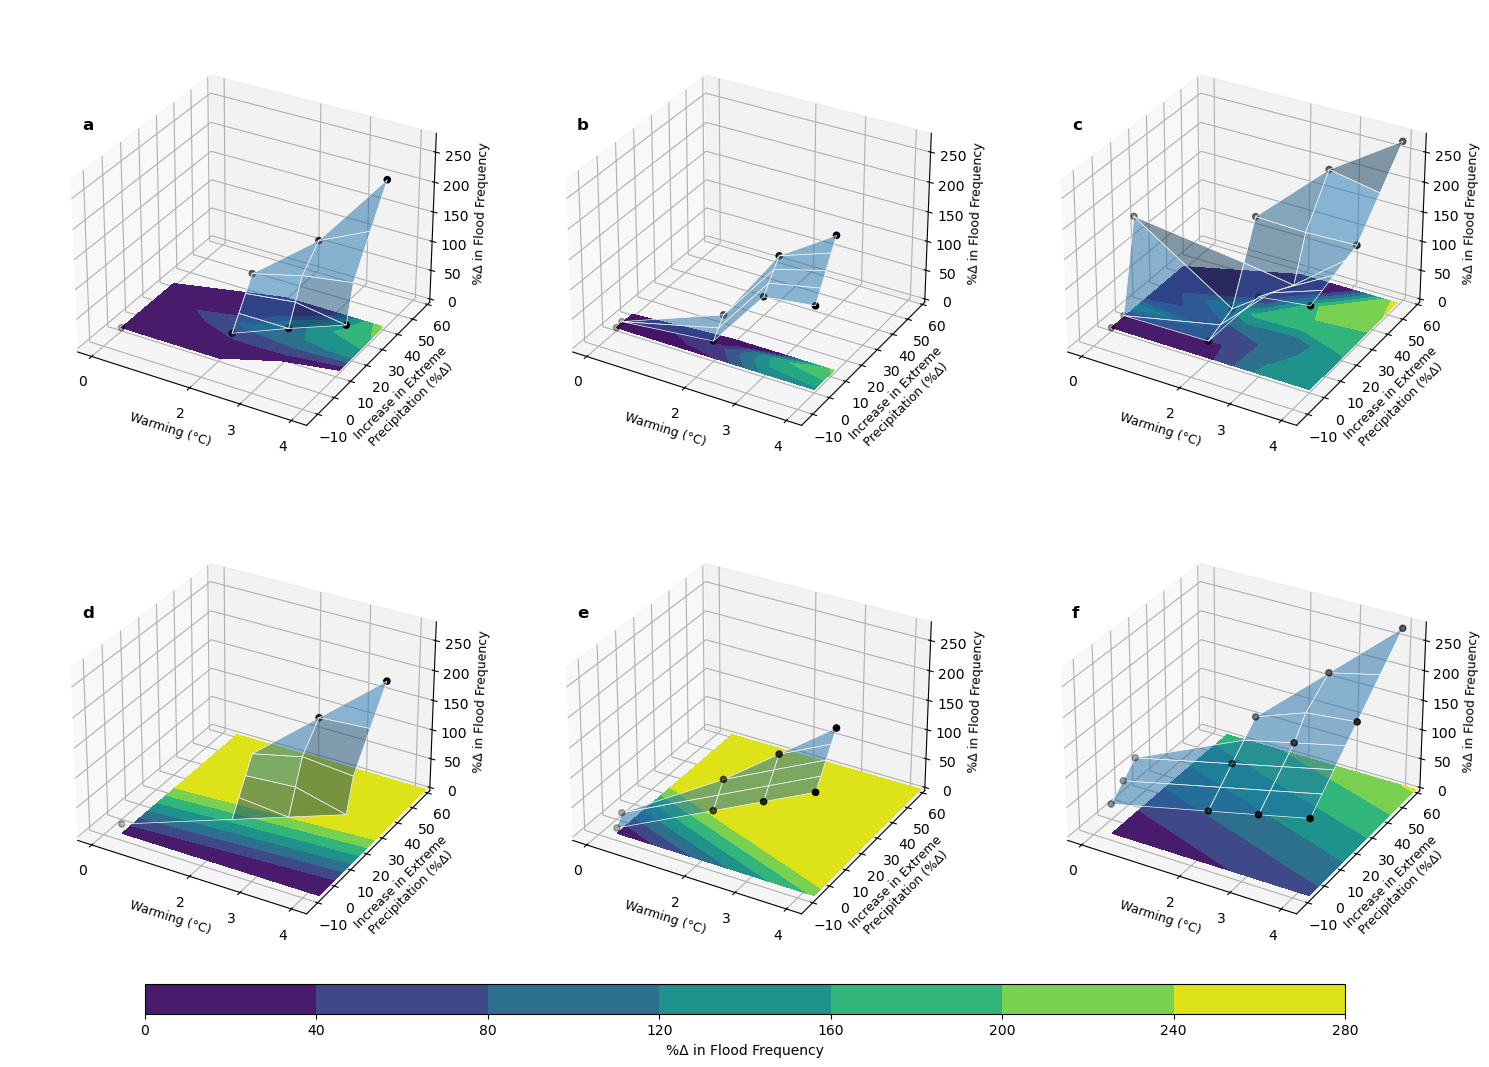

In [49]:
figure_9(dfs = supplimental_data(df_flood, scenario_groups))

### Figure S1. Hybrid Decomposition

In [50]:
def figure_s1(df):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3), subplot_kw={'projection': '3d'})
    # colorbar properties
    kw = {'vmin': -25, 'vmax': 325, 
          'levels': np.linspace(-25, 325, int((325-(-25))/25))}   
    
    
    # Simulated Values Contour Box #
    # fixed values for contour plots.
    _x1, _y1, _z1 = 4, 1, 1
    # simulated values.
    x1s, y1s, z1s = [0, 2, 3, 4], [3, 0, -3], [0, 7]
    X1, Y1, Z1 = np.meshgrid(np.array(x1s), np.array(y1s), np.array(z1s))
    # transform deltas into perturbations.
    petrb_cc = lambda x: 0 if x == 0 else 1
    petrb_pm = lambda x: -1 if x == -3 else 0 if x == 0 else 1
    
    def z_face_sims(df, xs, ys, _z):
        outer = []
        for y in ys:
            inner = []
            for x in xs:
                try:
                    v = df[(df['t'] == x) & (df['p_mean'] == petrb_pm(y)) & (df['cc'] == _z)]['percent_change'].item()
                except ValueError:
                    v = np.nan
                inner.append(v) 
            outer.append(inner)
        return np.array(outer)
    
    def y_face_sims(df, xs, _y, zs):
        outer = []  
        for x in xs:
            inner = []
            for z in zs:
                try:
                    v = df[(df['t'] == x) & (df['p_mean'] == _y) & (df['cc'] == petrb_cc(z))]['percent_change'].item()
                except ValueError:
                    v = np.nan
                inner.append(v)
            outer.append(inner)
        return np.array(outer)
    
    def x_face_sims(df, _x, ys, zs):
        outer = []
        for y in ys:
            inner = []
            for z in zs:
                try:
                    v = df[(df['t'] == _x) & (df['p_mean'] == petrb_pm(y)) & (df['cc'] == petrb_cc(z))]['percent_change'].item()
                except ValueError:
                    v = np.nan
                inner.append(v)   
            outer.append(inner)
        return np.array(outer)
    
    _ = axs[0].contourf(X1[:, :, 0], Y1[:, :, 0], z_face_sims(df, x1s, y1s, _z1), zdir='z', offset=7, **kw) # z face (t,p_mean) z=1
    _ = axs[0].contourf(X1[0, :, :], y_face_sims(df, x1s, _y1, z1s), Z1[0, :, :], zdir='y', offset=3, **kw) # y (t,cc) y=1 (flipped y axis)
    C = axs[0].contourf(x_face_sims(df, _x1, y1s, z1s), Y1[:, -1, :], Z1[:, -1, :], zdir='x', offset=4, **kw) # x face () x=4 face (p x cc)
    
    xmin, xmax = X1.min(), X1.max()
    ymin, ymax = Y1.min(), Y1.max()
    zmin, zmax = Z1.min(), Z1.max()
    axs[0].set(xlim=(xmin, xmax), ylim=(ymax, ymin), zlim=(zmin, zmax))
    axs[0].set(xticks=[0, 2, 3, 4], yticks=[-3, 0, 3], zticks=[0, 7])
    axs[0].set(xlabel='T (°C)', ylabel=r'$\Delta$P (%$\Delta$°C$^{-1}$)', zlabel=r'CC (%$\Delta$°C$^{-1}$)')
    axs[0].text2D(0.05, 0.85, 'a', transform=axs[0].transAxes, fontsize=12, fontweight='bold')
    
    # Predicted Values Contour Box #
    # transform perturbations into delta changes.
    delta_cc = lambda t, cc: t * cc * 7 if t > 0 else cc * 7
    delta_pm = lambda t, pm: t * pm * 3 if t > 0 else pm * 3
    
    def s2(df):
        df['delta_cc'] = df.apply(lambda row: delta_cc(row.t, row.cc), axis=1)
        df['delta_pmean'] = df.apply(lambda row: delta_pm(row.t, row.p_mean), axis=1)
        df['y_hat'] = smf.ols('flood_frequency~t+delta_cc+delta_pmean',df).fit(cov_type='HC1').fittedvalues
        base = df.loc[1, 'percent_change']
        df['percent_change'] = (df['flood_frequency'] - base) / base * 100
        df['percent_change_hat'] = (df['y_hat'] - base) / base * 100
        return df
    df2 = s2(df)
    
    _x2, _y2, _z2 = 4, 28, 28
    x2s, y2s, z2s = np.arange(0, 5), np.arange(28, -1, -1), np.arange(0, 29)
    X2, Y2, Z2 = np.meshgrid(np.array(x2s), np.array(y2s), np.array(z2s))
    params = smf.ols('flood_frequency~t+delta_cc+delta_pmean',df2).fit(cov_type='HC1').params
    
    def z_face_pred(xs, ys, _z):
        outer = []
        for y in ys:
            inner = []
            for x in xs:
                try:
                    vhat = ((params.Intercept + params.t * x + params.delta_pmean * y + params.delta_cc * _z) - params.Intercept) / params.Intercept * 100
                except ValueError:
                    vhat = np.nan
                inner.append(vhat) 
            outer.append(inner)
        return interpolate(np.array(outer))
    
    def y_face_pred(xs, _y, zs):
        outer = []  
        for x in xs:
            inner = []
            for z in zs:
                try:
                    vhat = ((params.Intercept + params.t * x + params.delta_pmean * _y + params.delta_cc * z) - params.Intercept) / params.Intercept * 100
                except ValueError:
                    vhat = np.nan
                inner.append(vhat)
            outer.append(inner)
        return interpolate(np.array(outer))
    
    def x_face_pred(_x, ys, zs):
        outer = []
        for y in ys:
            inner = []
            for z in zs:
                try:
                    vhat = ((params.Intercept + params.t * _x + params.delta_pmean * y + params.delta_cc * z) - params.Intercept) / params.Intercept * 100
                except ValueError:
                    vhat = np.nan
                inner.append(vhat)   
            outer.append(inner)
        return interpolate(np.array(outer))
    
    _ = axs[1].contourf(X2[:, :, 0], Y2[:, :, 0], z_face_pred(x2s, y2s, _z2), zdir='z', offset=28, **kw) # z face (t,p_mean) z=1
    _ = axs[1].contourf(X2[0, :, :], y_face_pred(x2s, _y2, z2s), Z2[0, :, :], zdir='y', offset=28, **kw) # y (t,cc) y=1 (flipped y axis)
    C = axs[1].contourf(x_face_pred(_x2, y2s, z2s), Y2[:, -1, :], Z2[:, -1, :], zdir='x', offset=4, **kw) # x face () x=4 face (p x cc)
    
    xmin, xmax = X2.min(), X2.max()
    ymin, ymax = Y2.min(), Y2.max()
    zmin, zmax = Z2.min(), Z2.max()
    axs[1].set(xlim=(xmin, xmax), ylim=(ymax, ymin), zlim=(zmin, zmax))
    axs[1].set(xticks=[0, 2, 3, 4])
    axs[1].set(xlabel='T (°C)', ylabel=r'$\Delta$P (%$\Delta$)', zlabel=r'CC (%$\Delta$)')
    axs[1].text2D(0.05, 0.85, 'b', transform=axs[1].transAxes, fontsize=12, fontweight='bold') 
    
    #plt.subplots_adjust(wspace=0.5, hspace=0.5)
    ax_cbar = fig.add_axes([0.1, -0.1, 0.8, 0.03])
    fig.colorbar(C, cax=ax_cbar, orientation='horizontal', label='%Δ in Flood Frequency')
    fig.set_constrained_layout(True) #w_pad=2./72., h_pad=2./72., hspace=0.5, wspace=0.5
    fig.set_constrained_layout_pads(w_pad=1.22, h_pad=0.05)
    plt.show()
    

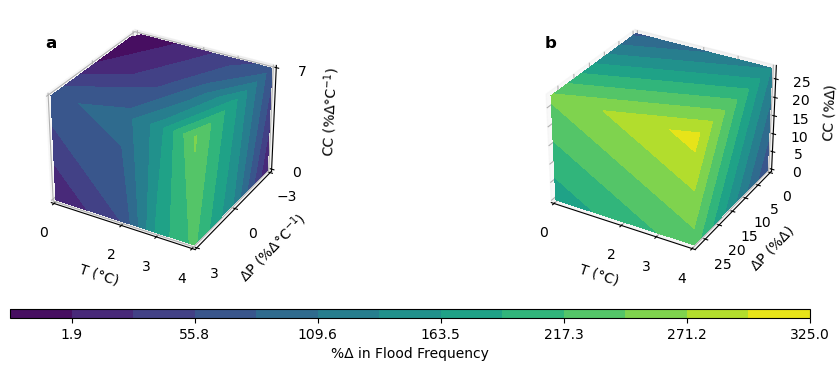

In [51]:
figure_s1(supplimental_data(df_flood, scenario_groups)[-1])